# Fluid pumps dataset EDA

In [1]:
import os
from typing import List, Tuple
from datetime import datetime, date
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy.signal import windows
import matplotlib.pylab as plt
from scipy.signal import welch

In [2]:
path_root = '../../datasets/'
path_features = os.path.join(path_root, 'features')
dataset = 'FluidPump.zip'
name = dataset.split('.')[0].lower()

opt = {
    'dataset': os.path.join(path_root, dataset),
    'temporal_features': os.path.join(path_features, f'{name}_temporal.csv'),
    'spectral_features': os.path.join(path_features, f'{name}_spectral.csv'),
}

#### Side by side welch spectra from same places on different days

In [3]:
fluidpump_columns = ['x', 'y', 'z']
fluidpump_all_columns = ['t', 'x', 'y', 'z']
fluidpump_fs_hz = 26866

def list_files(dataset: ZipFile) -> List[str]:
    filenames = [
        f.filename
        for f in dataset.infolist()
        if f.filename.endswith(('.csv', '.tsv'))
    ]
    filenames.sort()
    return filenames

def fluidpump_csv_import(dataset: ZipFile, filename: str) -> pd.DataFrame:
    ts = pd.read_csv(
        dataset.open(filename),
        delimiter='\t',
        index_col=False,
        header=0,
        names=fluidpump_all_columns
    ) 
    g = 9.80665
    columns = fluidpump_columns
    ts[columns] = ts[columns].apply(lambda x: g * (x / 1000))

    T = 1 / fluidpump_fs_hz
    ts = (
        ts
        .assign(t = lambda x: x.index * T)
    )
    ts.set_index('t', inplace=True)
    return ts

In [4]:
source = ZipFile(opt['dataset'])
filenames = list_files(source)

waveforms = []
all_metadata = []
for name in filenames:
    ts = fluidpump_csv_import(source, name)
    header = name.split(os.path.sep)
    metadata = {
        'place': header[-5],
        'date': datetime.fromisoformat(header[-4]).date(),
        'device': header[-3],
        'position': header[-2],
        'seq': int(header[-1].split('.')[0]),
        'ts': ts
    }
    metacopy = metadata.copy()
    metacopy.pop('ts')

    all_metadata.append(metacopy)
    waveforms.append(metadata)

In [5]:
all_metadata = pd.DataFrame.from_records(all_metadata)
all_metadata

place        date device   position  seq
0   compressor  2024-02-20     K3        001    1
1   compressor  2024-02-20     K3        001    2
2   compressor  2024-02-20     K3        001    3
3   compressor  2024-02-20     K3        002    1
4   compressor  2024-02-20     K3        002    2
5   compressor  2024-02-20     K3        002    3
6   compressor  2024-02-20     K5        001    1
7   compressor  2024-02-20     K5        001    2
8   compressor  2024-02-20     K5        001    3
9   compressor  2024-02-20     K5        002    1
10  compressor  2024-02-20     K5        002    2
11  compressor  2024-02-20     K5        002    3
12  compressor  2024-03-05     K3        001    1
13  compressor  2024-03-05     K3        001    2
14  compressor  2024-03-05     K3        001    3
15  compressor  2024-03-05     K3        002    1
16  compressor  2024-03-05     K3        002    2
17  compressor  2024-03-05     K3        002    3
18  compressor  2024-03-05     K5        001    1
19  compressor  2024-03-05     K5        001    2
20  compressor  2024-03-05     K5        001    3
21  compressor  2024-03-05     K5        002    1
22  compressor  2024-03-05     K5        002    2
23  compressor  2024-03-05     K5        002    3
24        pump  2024-02-27  KSB-1  MTR-noise    1
25        pump  2024-02-27  KSB-1     MTR001    1
26        pump  2024-02-27  KSB-1     MTR001    2
27        pump  2024-02-27  KSB-1     MTR001    3
28        pump  2024-02-27  KSB-1     MTR002    1
29        pump  2024-02-27  KSB-1     MTR002    2
30        pump  2024-02-27  KSB-1     MTR002    3
31        pump  2024-02-27  KSB-1  PMP-noise    1
32        pump  2024-02-27  KSB-1     PMP003    1
33        pump  2024-02-27  KSB-1     PMP003    2
34        pump  2024-02-27  KSB-1     PMP003    3
35        pump  2024-02-27  KSB-1     PMP004    1
36        pump  2024-02-27  KSB-1     PMP004    2
37        pump  2024-02-27  KSB-1     PMP004    3
38        pump  2024-02-27  KSB-7  MTR-noise    1
39        pump  2024-02-27  KSB-7     MTR001    1
40        pump  2024-02-27  KSB-7     MTR001    2
41        pump  2024-02-27  KSB-7     MTR001    3
42        pump  2024-02-27  KSB-7     MTR002    1
43        pump  2024-02-27  KSB-7     MTR002    2
44        pump  2024-02-27  KSB-7     MTR002    3
45        pump  2024-02-27  KSB-7  PMP-noise    1
46        pump  2024-02-27  KSB-7     PMP003    1
47        pump  2024-02-27  KSB-7     PMP003    2
48        pump  2024-02-27  KSB-7     PMP003    3
49        pump  2024-02-27  KSB-7     PMP004    1
50        pump  2024-02-27  KSB-7     PMP004    2
51        pump  2024-02-27  KSB-7     PMP004    3

In [6]:
def spectral_transform(dataset: pd.DataFrame, axis: str, window: int, fs: int) -> Tuple[np.array, np.array]:
    overlap = 0.5
    step = int(window * overlap)

    v = dataset[axis].to_numpy()
    f, pxx = welch(
        v,
        fs=fs,
        window='hann',
        nperseg=window,
        noverlap=step,
        scaling='spectrum',
        average='mean',
        detrend='constant',
        return_onesided=True
    )
    return f, pxx


def side_by_side(
        waveforms: list,
        location: str,
        plot_type: str = 'psd', # psd, psd_db, hist
        axis: str = 'x',
        filt_pos: str | None = None,
        figsize: tuple | None = None,
        ylim: tuple | None = None):
        
    machines = filter(lambda m: m['place'] == location, waveforms)
    if filt_pos is not None:
        machines = filter(lambda m: filt_pos in m['position'], machines)
        if 'noise' not in filt_pos:
            machines = filter(lambda m: '-noise' not in m['position'], machines)

    machines = list(machines)
    columns = set([(c['device'], c['position']) for c in machines])
    rows = len(machines) // len(columns)

    if figsize is None:
        figsize = (15, 20)
    fig, ax = plt.subplots(rows, len(columns), figsize=figsize, sharey=True)
    if rows == 1:
        ax = [ax]

    for j, col in enumerate(sorted(list(columns))):
        device, position = col
        placements = list(filter(lambda m: m['device'] == device and m['position'] == position, machines))
        
        for i, row in enumerate(sorted(placements, key=lambda m: (m['date'], m['seq']))):
            date, seq = row['date'], row['seq']
            ts = row['ts']
            subplot = ax[i][j]
        
            if plot_type == 'psd':
                freqs, pxx = spectral_transform(ts, axis, 2**14, Fs)
                subplot.plot(freqs / 1000, pxx, color='darkblue', linewidth=0.5)

                subplot.set_xlim(0, 5)
                ax[-1][j].set_xlabel('Frequency [kHz]')
                ax[i][0].set_ylabel('Amplitude [m/s\u00B2]')
    
            elif plot_type == 'psd_db':
                freqs, pxx = spectral_transform(ts, axis, 2**14, Fs)
                pxx = dB = 20 * np.log10(pxx / 0.000001) # 1 dB = 1 um/s^2   
                subplot.plot(freqs / 1000, pxx, color='darkblue', linewidth=0.5)

                subplot.set_xlim(0, 5)
                ax[-1][j].set_xlabel('Frequency [kHz]')
                ax[i][0].set_ylabel('Amplitude [dB]')

            elif plot_type == 'hist':
                subplot.hist(ts[axis], color='darkblue', bins=100, edgecolor='black', linewidth=0.5)

                ax[-1][j].set_xlabel('Amplitude [m/s\u00B2]')
                ax[i][0].set_ylabel('Count samples')
            
            if ylim is not None:
                subplot.set_ylim(0, ylim)

            subplot.grid(True)
            subplot.set_title(f'{device}, {position} | {date}, {seq}.')
                
    plt.tight_layout()
    plt.show()

#### Plot one spectrum in all axis

In [7]:
query = {
    'place': 'compressor',
    'date': date(2024, 2, 20),
    'device': 'K3',
    'position': '001',
    'seq': 1
}
F_LIMIT_KHZ = 2
axis = fluidpump_columns
Fs = fluidpump_fs_hz

signal = filter(
    lambda s: (
        s['place'] == query['place'] and
        s['date'] == query['date'] and
        s['device'] == query['device'] and
        s['position'] == query['position'] and
        s['seq'] == query['seq']
    ),
    waveforms
)
ts = list(signal)[0]['ts']
ts

x         y          z
t                                        
0.000000   -5.982056 -3.171667  17.580087
0.000037   -6.539565 -3.938547  18.306270
0.000074   -7.692925 -2.471766   9.047223
0.000112  -10.119286 -0.066979   5.543013
0.000149  -10.542737  1.058824   5.214000
...              ...       ...        ...
59.878285  -9.251888 -2.664369   2.398805
59.878322  -9.367900 -3.298467  10.129975
59.878359 -10.095358 -4.185086   5.021299
59.878396  -8.546005  0.387657  -5.994021
59.878434  -9.305726  4.786822  -7.007342

[1608695 rows x 3 columns]

Histograms

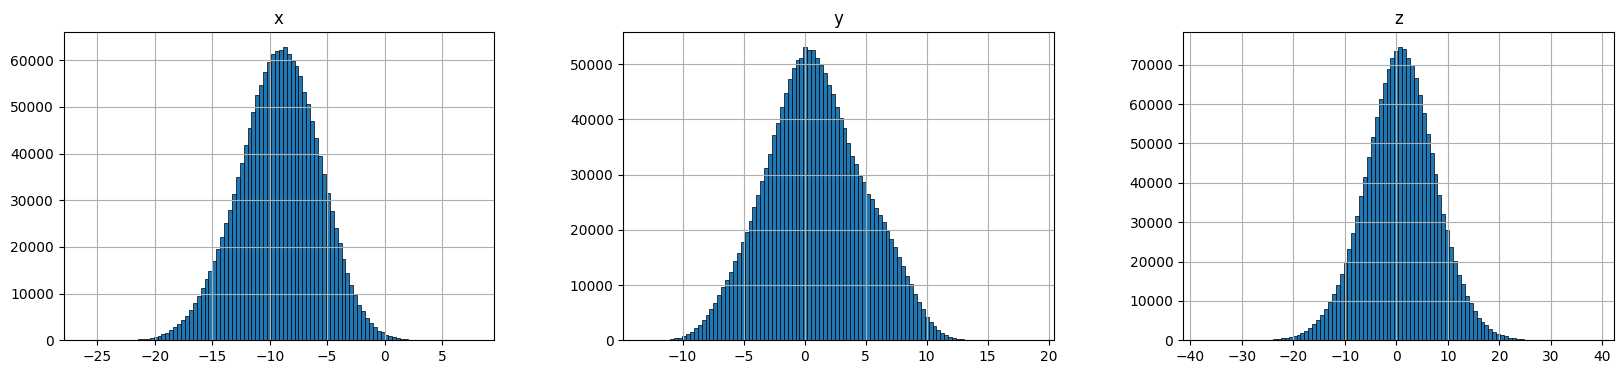

In [8]:
ax = ts.hist(figsize=(20, 4), grid=True, bins=100, layout=(1, 3), edgecolor='black', linewidth=0.5)
plt.show()

Waveform in full length

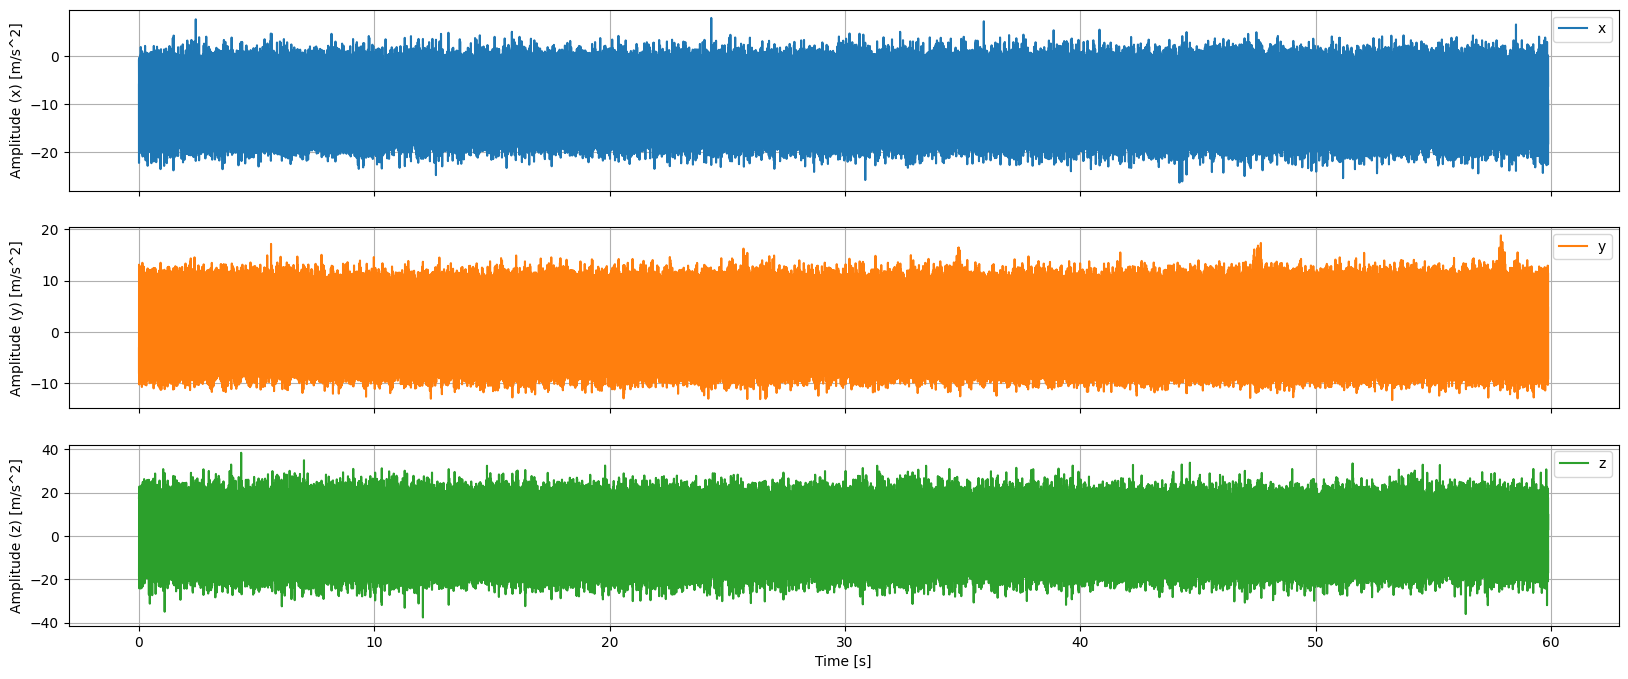

In [9]:
ax = ts.plot(figsize=(20, 8), grid=True, subplots=True)
for i, axname in enumerate(axis):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({axname}) [m/s^2]')
plt.show() 

Waveform in detail: T_WAVEFORM s and interval of TIME s

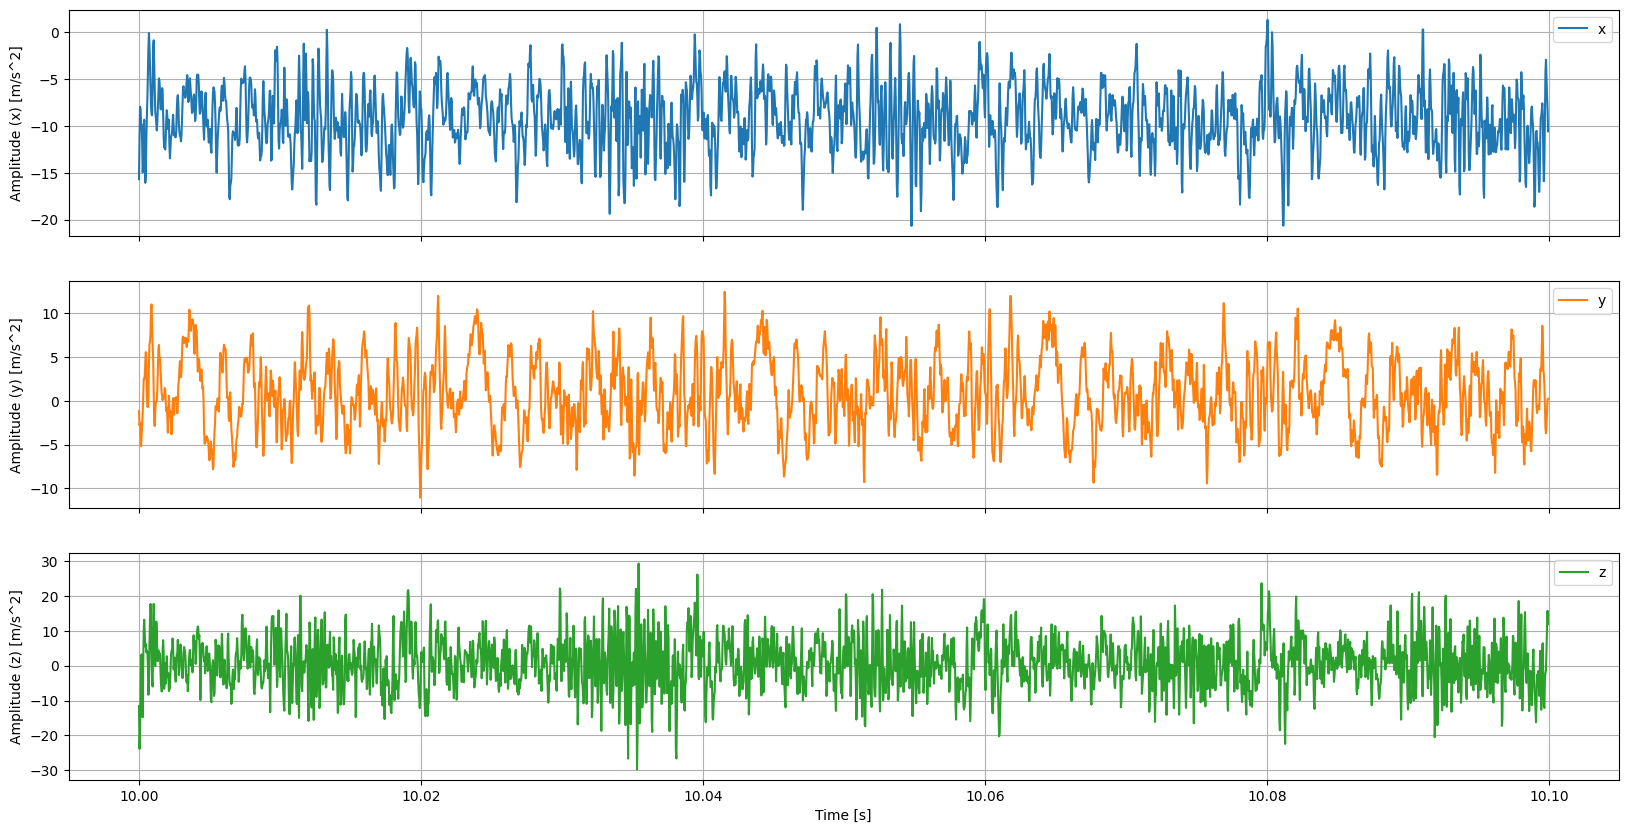

In [10]:
T_WAVEFORM = 10
TIME = 0.1

ax = (ts[axis].iloc[int(T_WAVEFORM*Fs):int(T_WAVEFORM*Fs+Fs*TIME)]
                  .plot(figsize=(20, 10), grid=True, subplots=True))
    
for i, axname in enumerate(axis):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({axname}) [m/s^2]')
plt.show() 

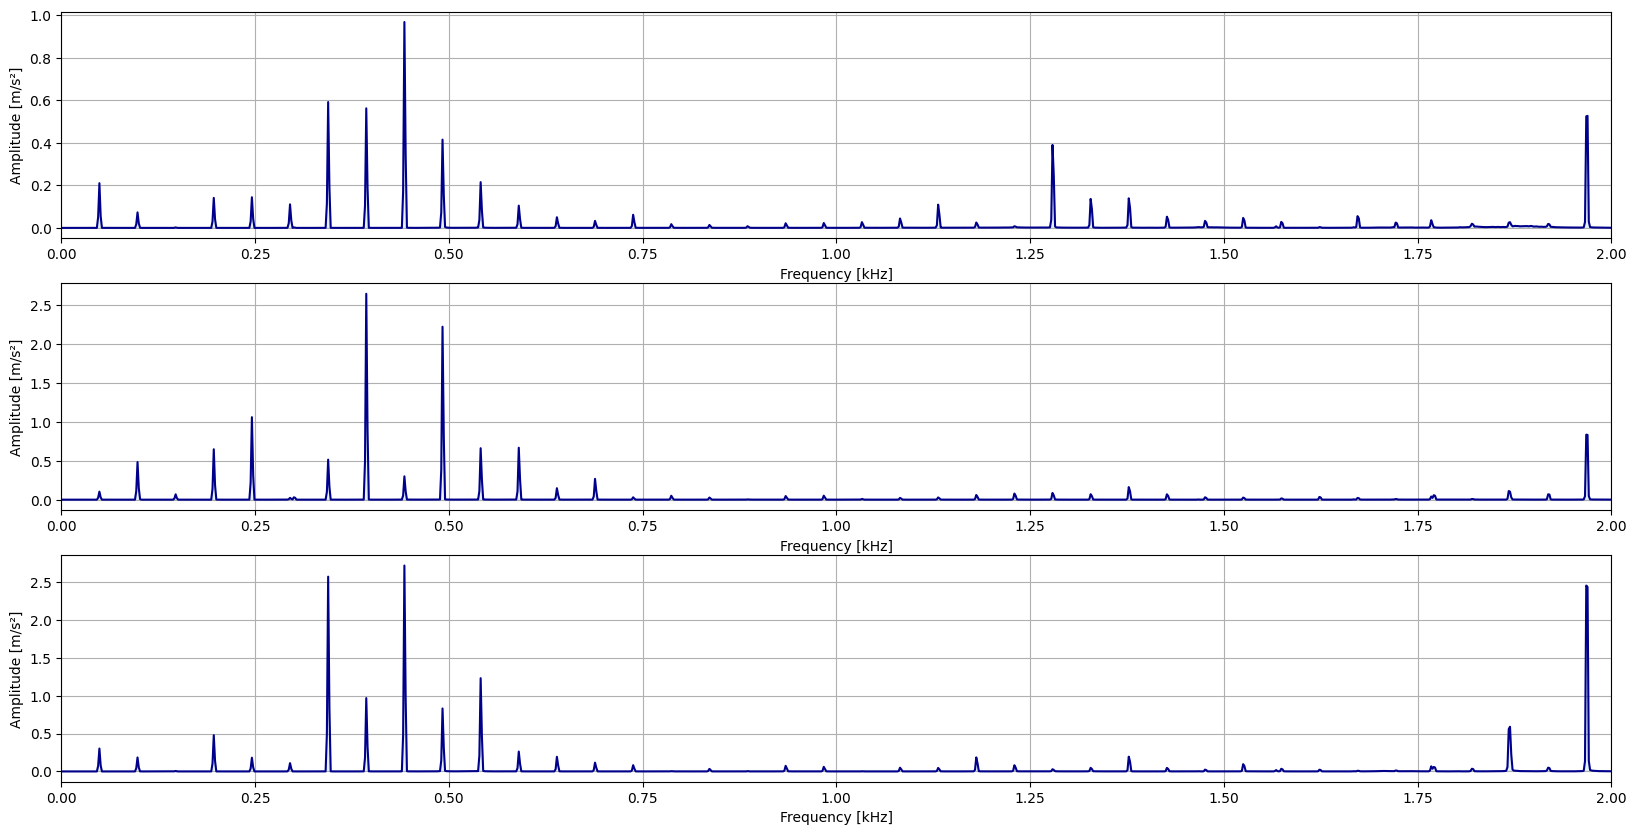

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ts_range = ts[:]
#ts_range = ts.loc[:10]

for i, axname in enumerate(axis):
    freqs, pxx = spectral_transform(ts_range, axname, 2**14, Fs)
    freqs /= 1000
    ax[i].plot(freqs, pxx, color='darkblue')
    ax[i].fill_between(freqs, pxx, color='lightblue', alpha=0.3)
    ax[i].grid(True)
    ax[i].set_xlim(0, F_LIMIT_KHZ)
    ax[i].set_xlabel('Frequency [kHz]')
    ax[i].set_ylabel('Amplitude [m/s\u00B2]')

Frequency spectrum of one window

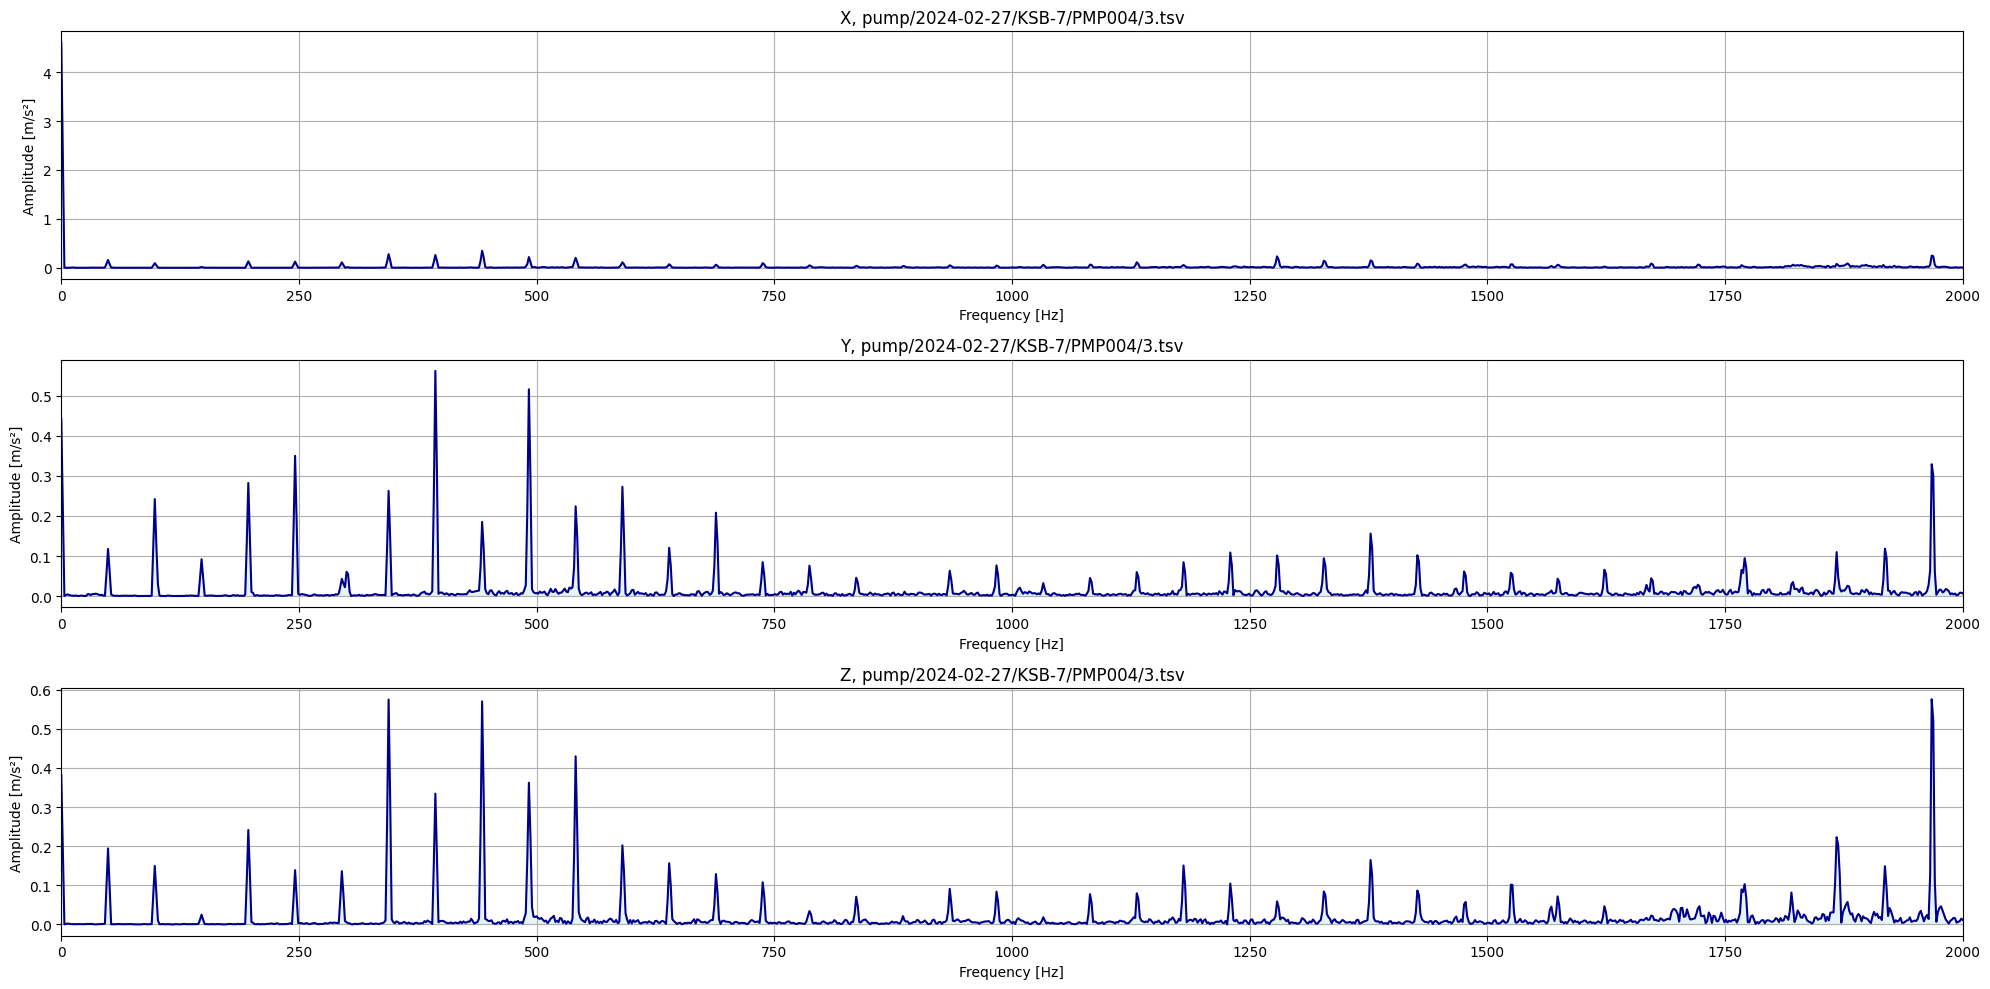

In [12]:
def window_frequency_spectrum(ts: pd.DataFrame, t: float, nfft: int = 2**14, dB=False):
    fig, ax = plt.subplots(len(axis), 1, figsize=(20, 10))
    i = 0
    for axname in axis:
        signal = ts[axname].loc[t:t+nfft/Fs].to_numpy()
        n = len(signal)
        pxx = np.abs(np.fft.rfft(signal * windows.hann(n)) / n)
        if dB is True:
            pxx = 20 * np.log10(pxx / 0.000001)  # 1 dB = 1 um/s^2    
        freqs = np.fft.fftfreq(n, d=1/Fs)[:len(pxx)]

        ax[i].plot(freqs, pxx, color='darkblue')
        ax[i].fill_between(freqs, pxx, color='lightblue', alpha=0.3)
        ax[i].grid(True)
        ax[i].set_xlabel('Frequency [Hz]')
        ax[i].set_ylabel('Amplitude [m/s\u00B2]')
        ax[i].set_xlim(0, F_LIMIT_KHZ * 1000)
        ax[i].set_title(f'{axname.upper()}, {name}')
        i += 1
    plt.tight_layout()
    plt.show()


window_frequency_spectrum(ts, t=10, dB=False)

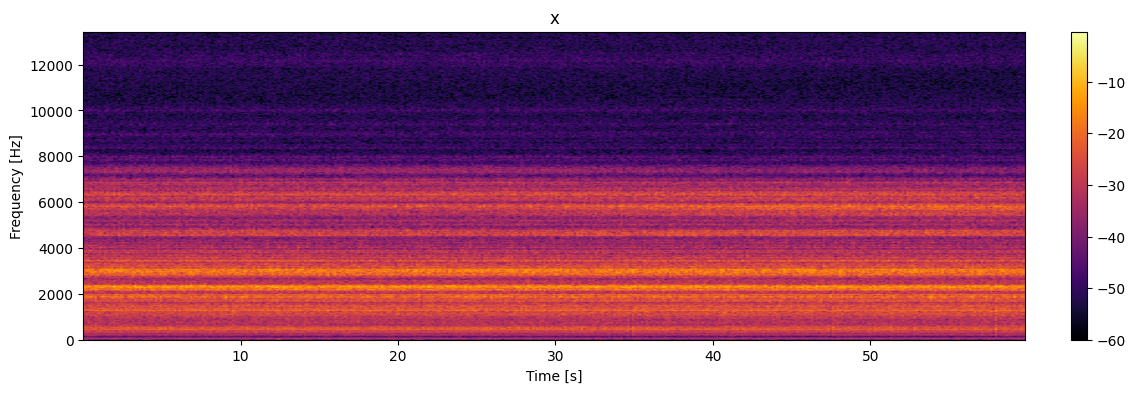

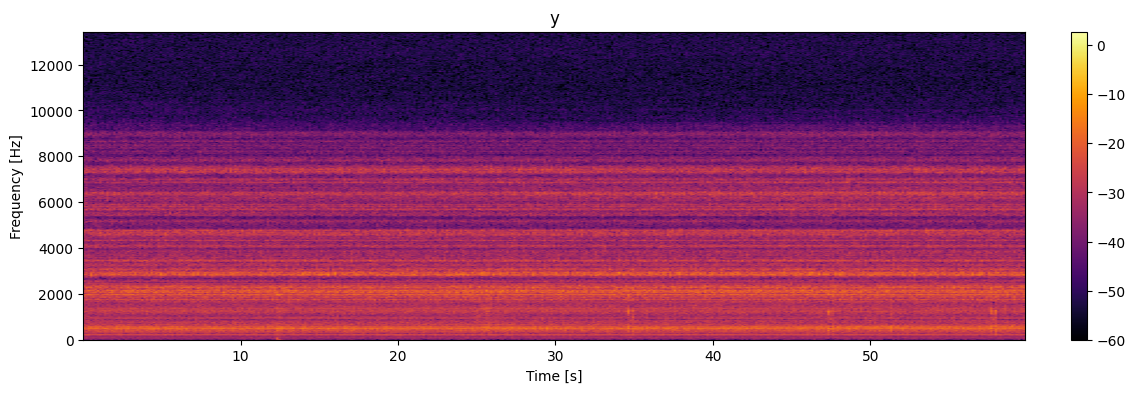

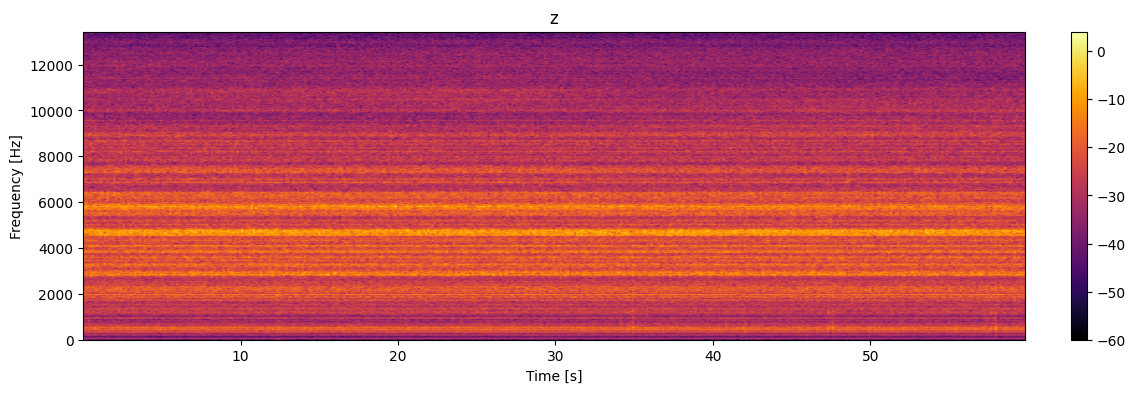

In [13]:
def spectogram(x, axname, nfft):
    fig, ax = plt.subplots(figsize=(15, 4))
    cmap = plt.get_cmap('inferno')
    pxx, freqs, t, im = plt.specgram(
        x, NFFT=nfft, Fs=Fs,
        detrend='mean',
        mode='magnitude', scale='dB',
        cmap=cmap, vmin=-60
    )
    fig.colorbar(im, aspect=20, pad=0.04)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_title(f'{axname}')
    return freqs, pxx

for axname in axis:
    freqs, Pxx = spectogram(ts[axname], axname, nfft=2**12)
    plt.show()

### Choose measurement direction

In [14]:
AXIS = 'x'          # x, y, z

### Noise

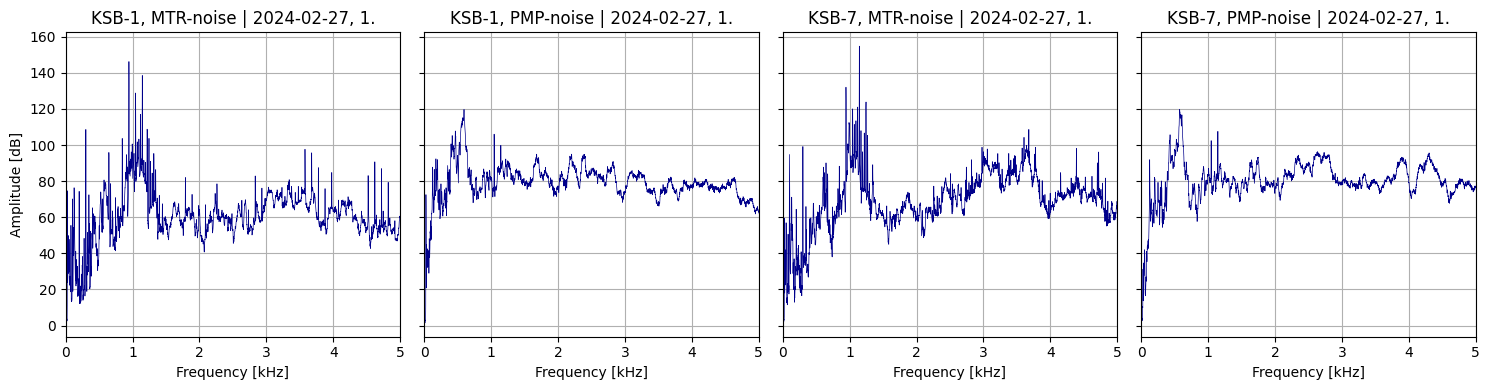

In [15]:
side_by_side(waveforms, 'pump', 'psd_db', AXIS, filt_pos='noise', figsize=(15, 4))

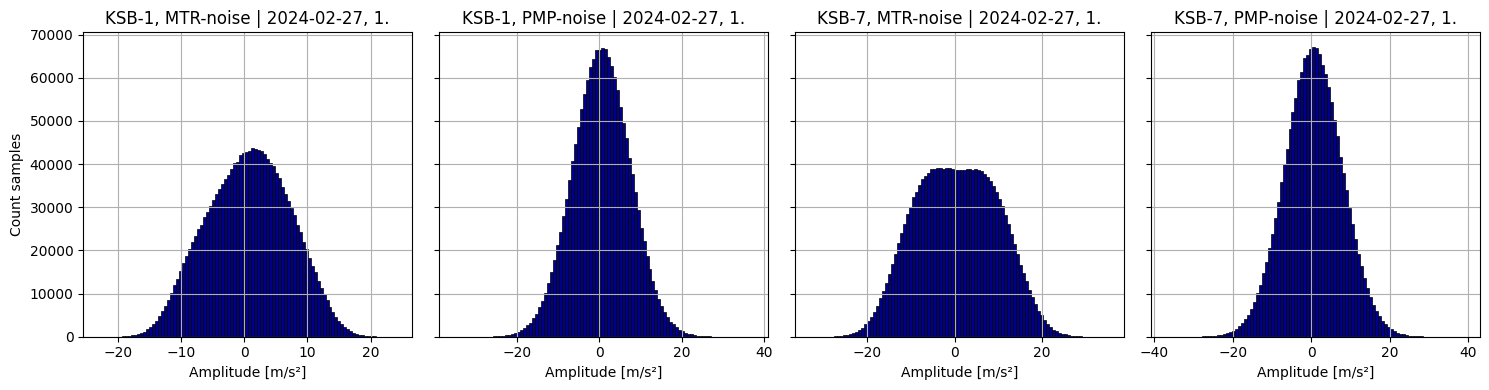

In [16]:
side_by_side(waveforms, 'pump', 'hist', AXIS, filt_pos='noise', figsize=(15, 4))

### Frequency spectra

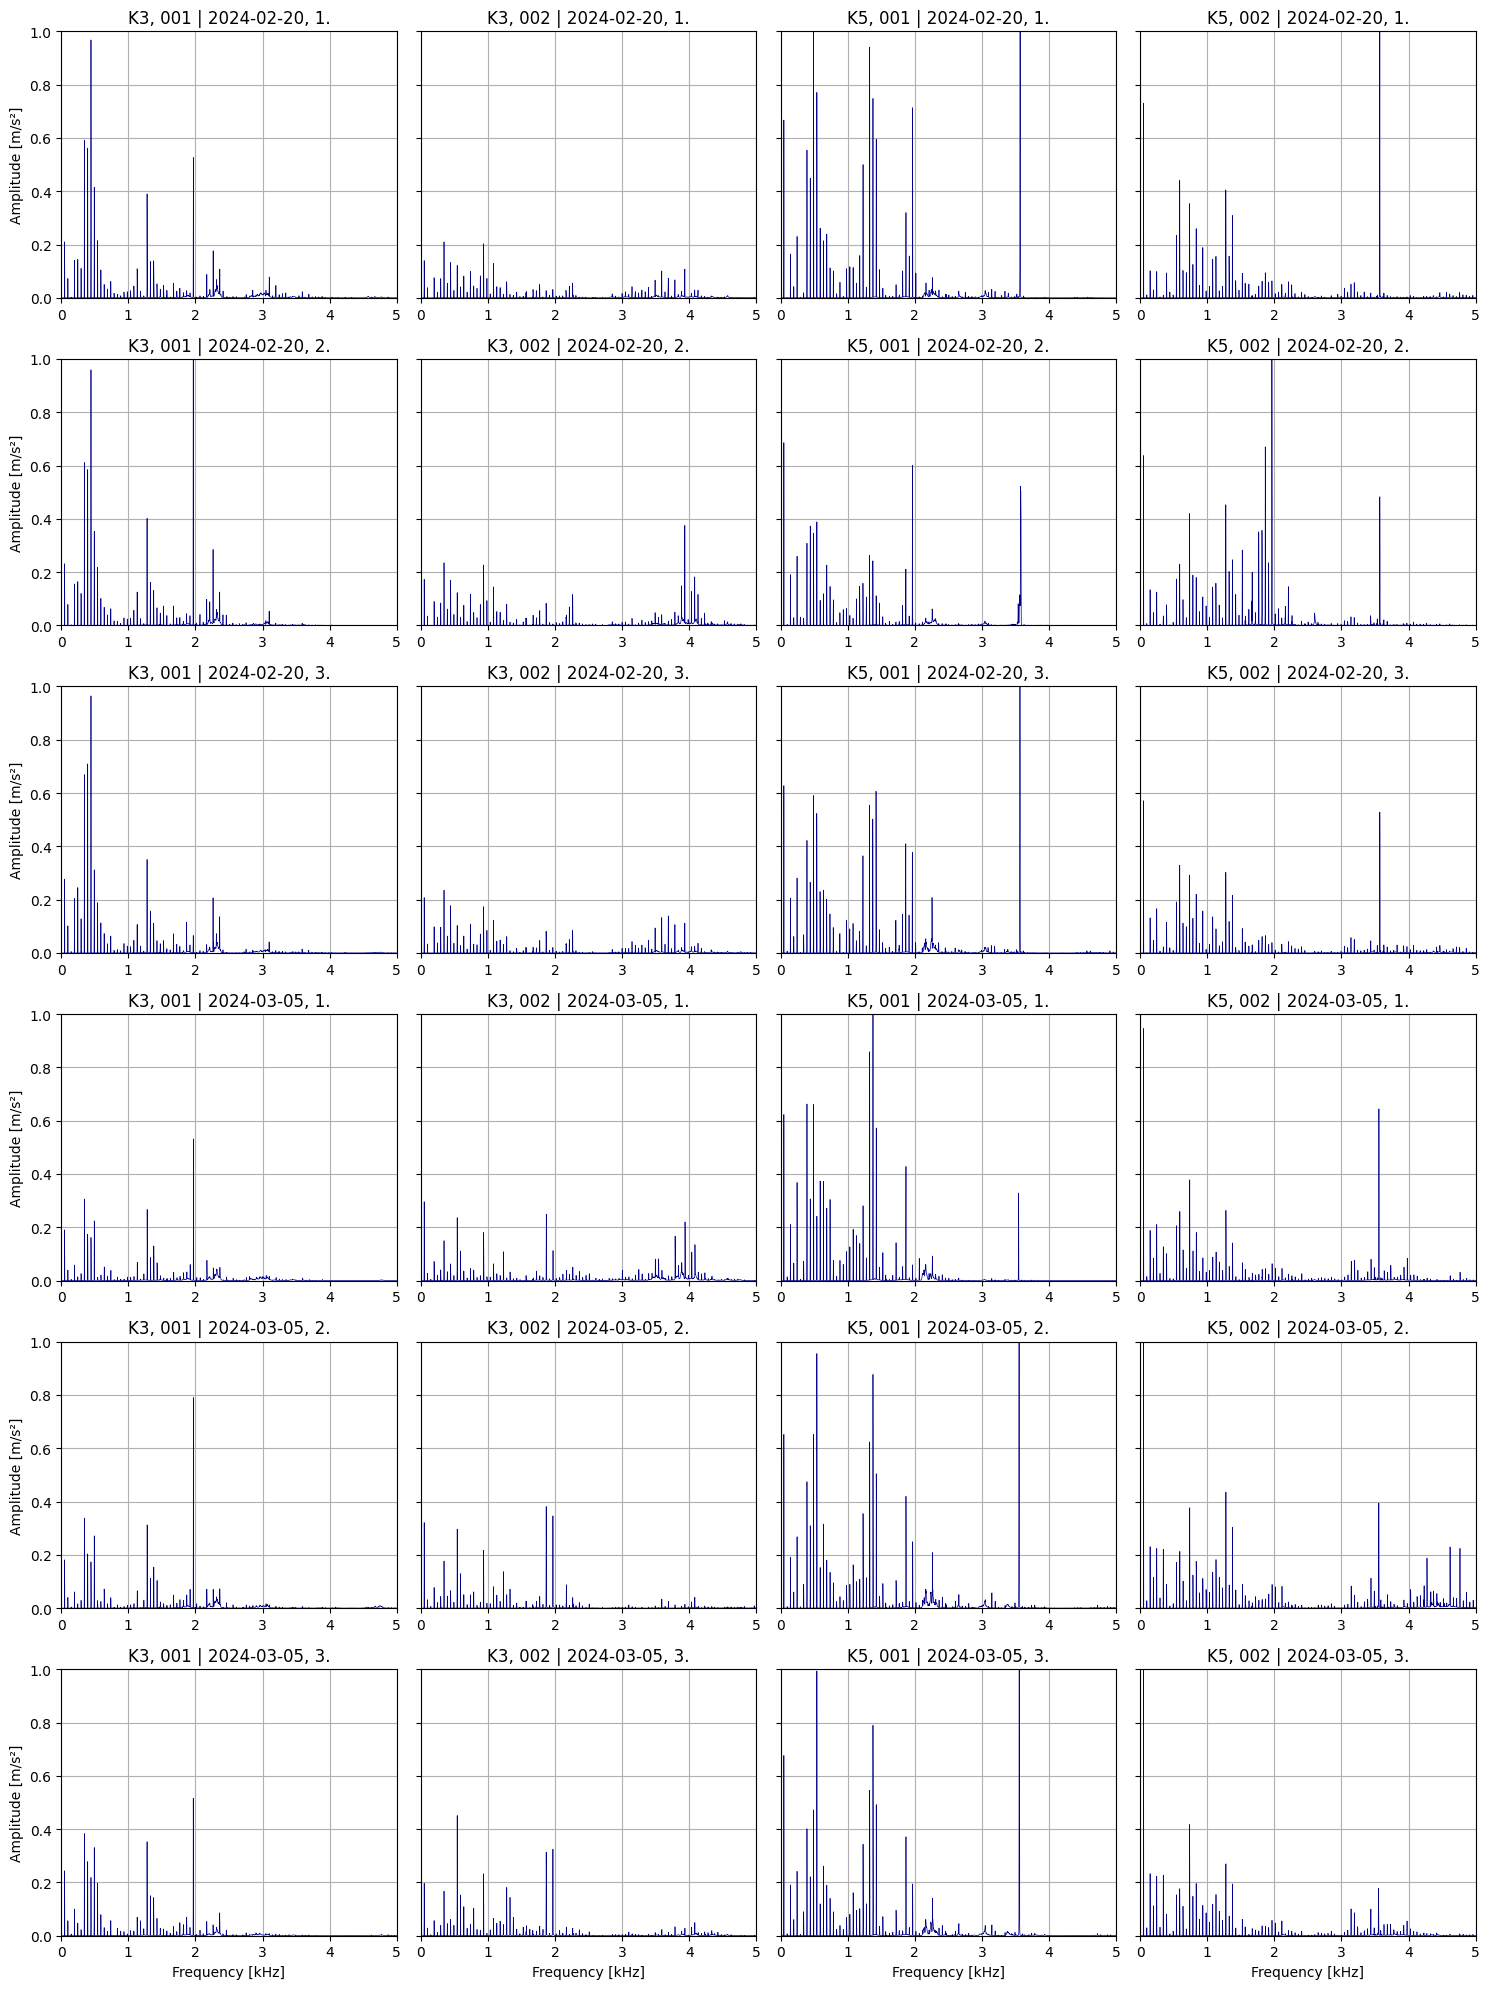

In [17]:
side_by_side(waveforms, 'compressor', 'psd', AXIS, figsize=(15, 20), ylim=1)

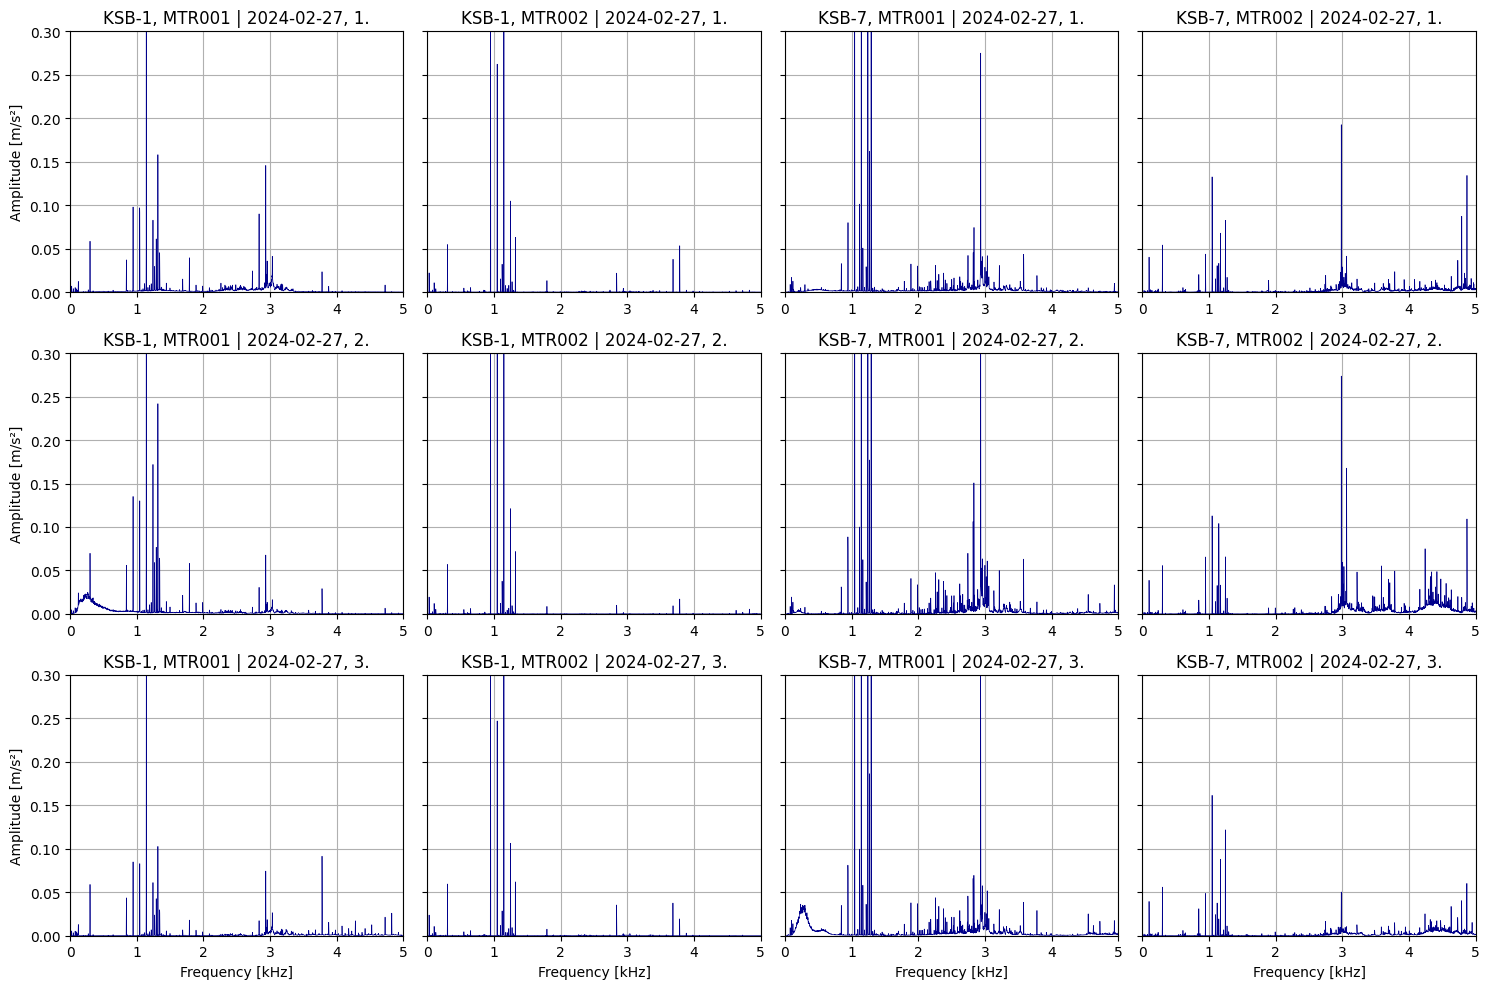

In [18]:
side_by_side(waveforms, 'pump', 'psd', AXIS, filt_pos='MTR', figsize=(15, 10), ylim=0.3)

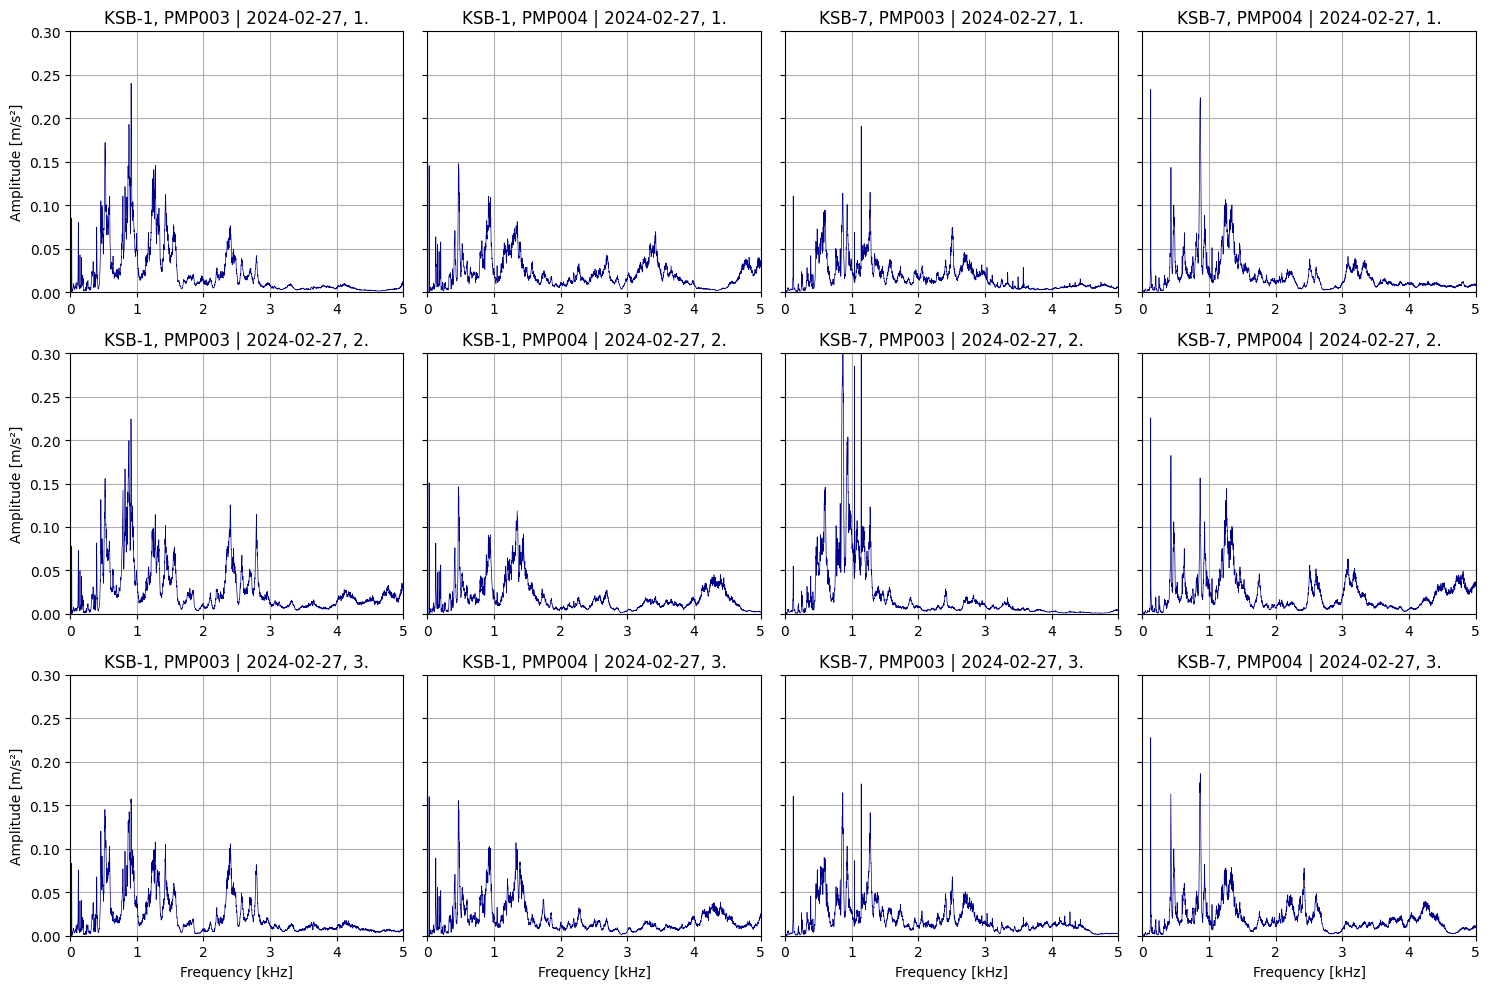

In [19]:
side_by_side(waveforms, 'pump', 'psd', AXIS, filt_pos='PMP', figsize=(15, 10), ylim=0.3)

### Decibel frequency spectra

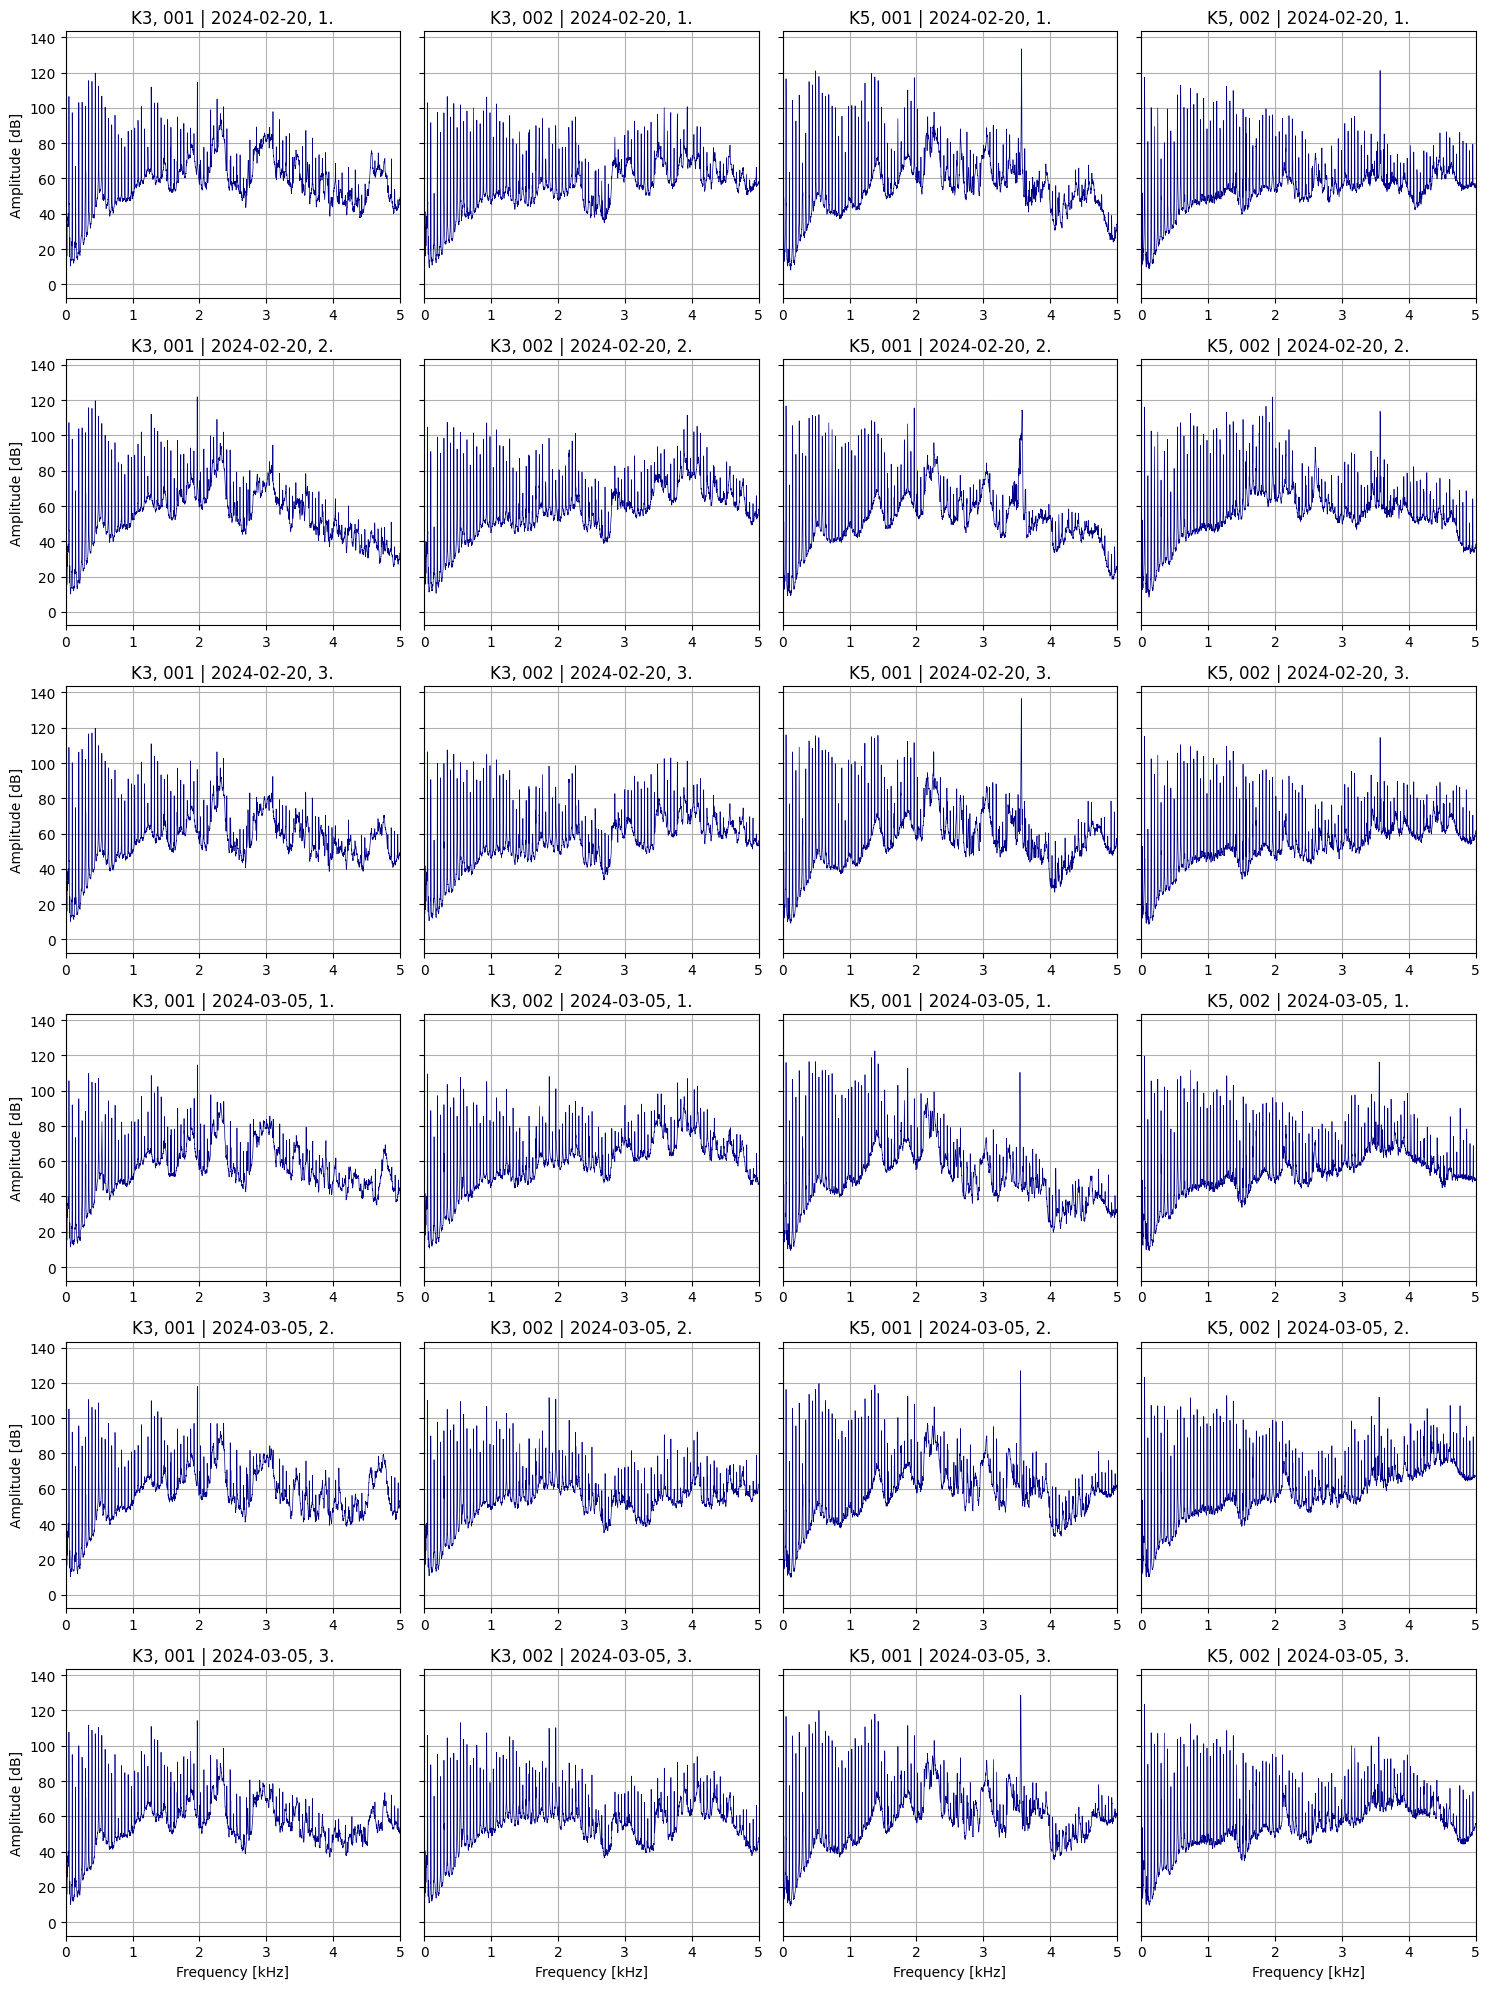

In [20]:
side_by_side(waveforms, 'compressor', 'psd_db', AXIS, figsize=(15, 20))

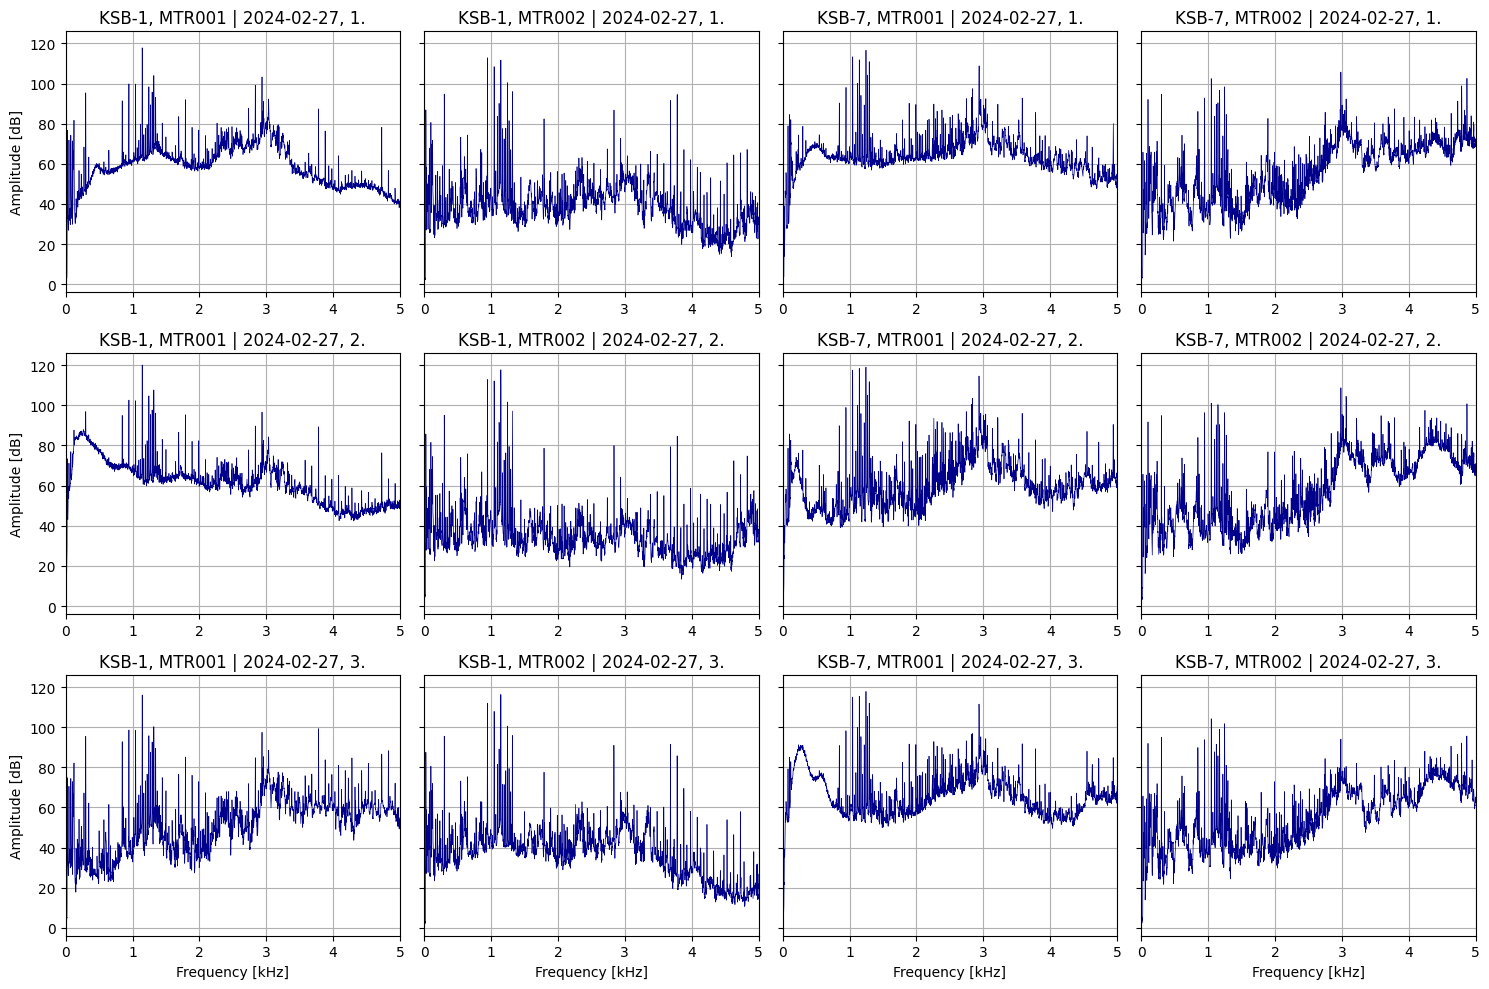

In [21]:
side_by_side(waveforms, 'pump', 'psd_db', AXIS, filt_pos='MTR', figsize=(15, 10))

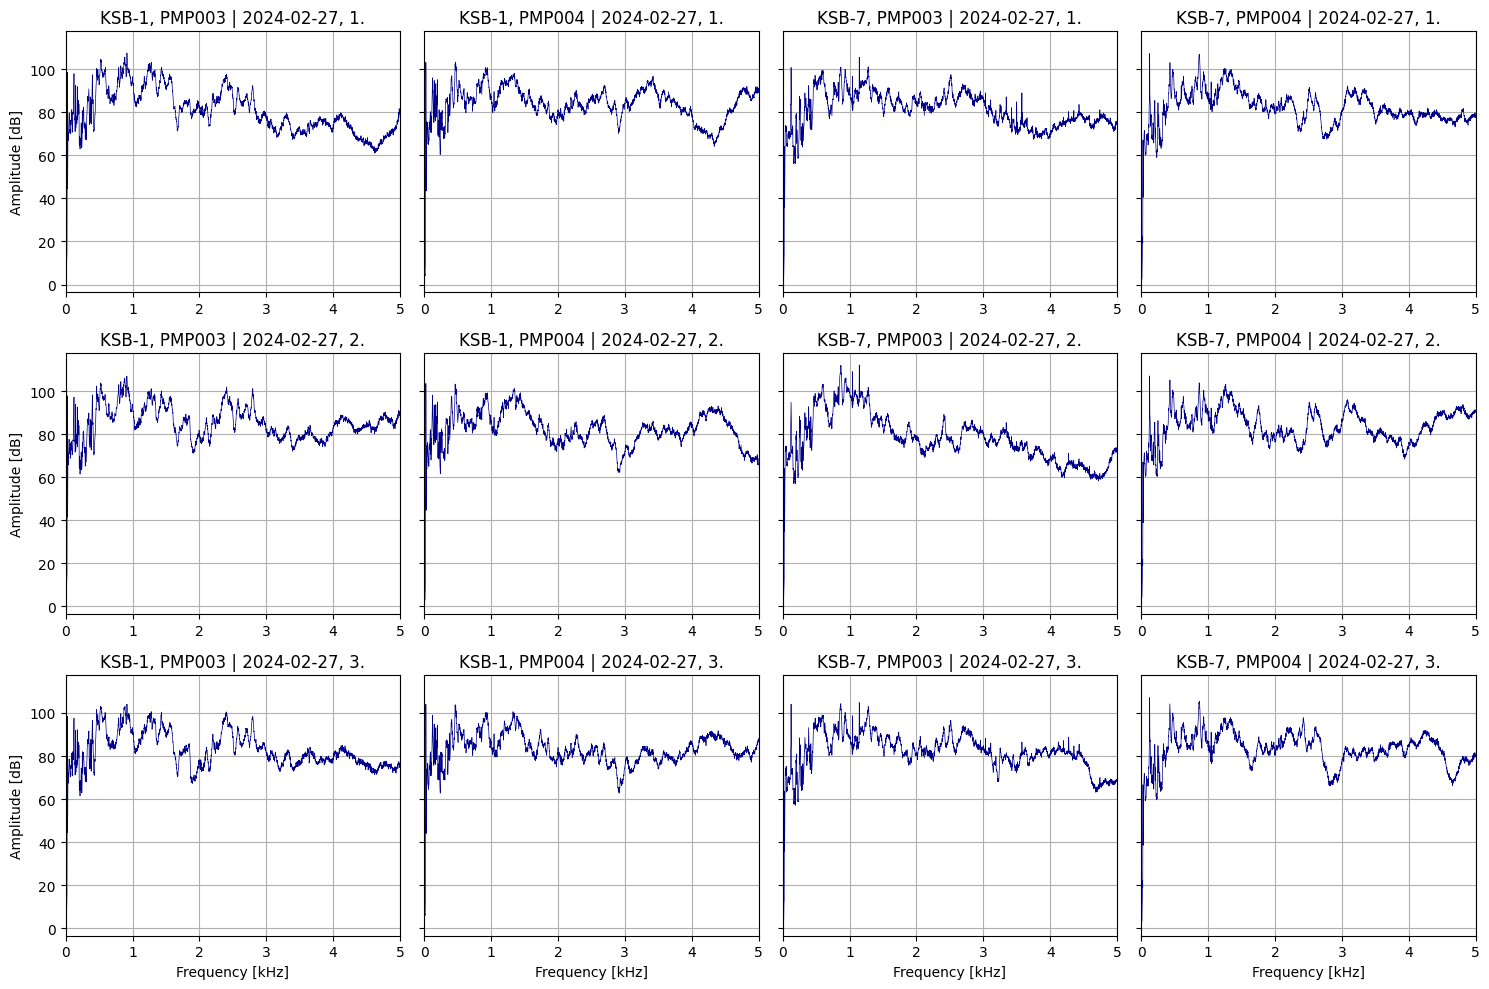

In [22]:
side_by_side(waveforms, 'pump', 'psd_db', AXIS, filt_pos='PMP', figsize=(15, 10))

### Histograms of time domain

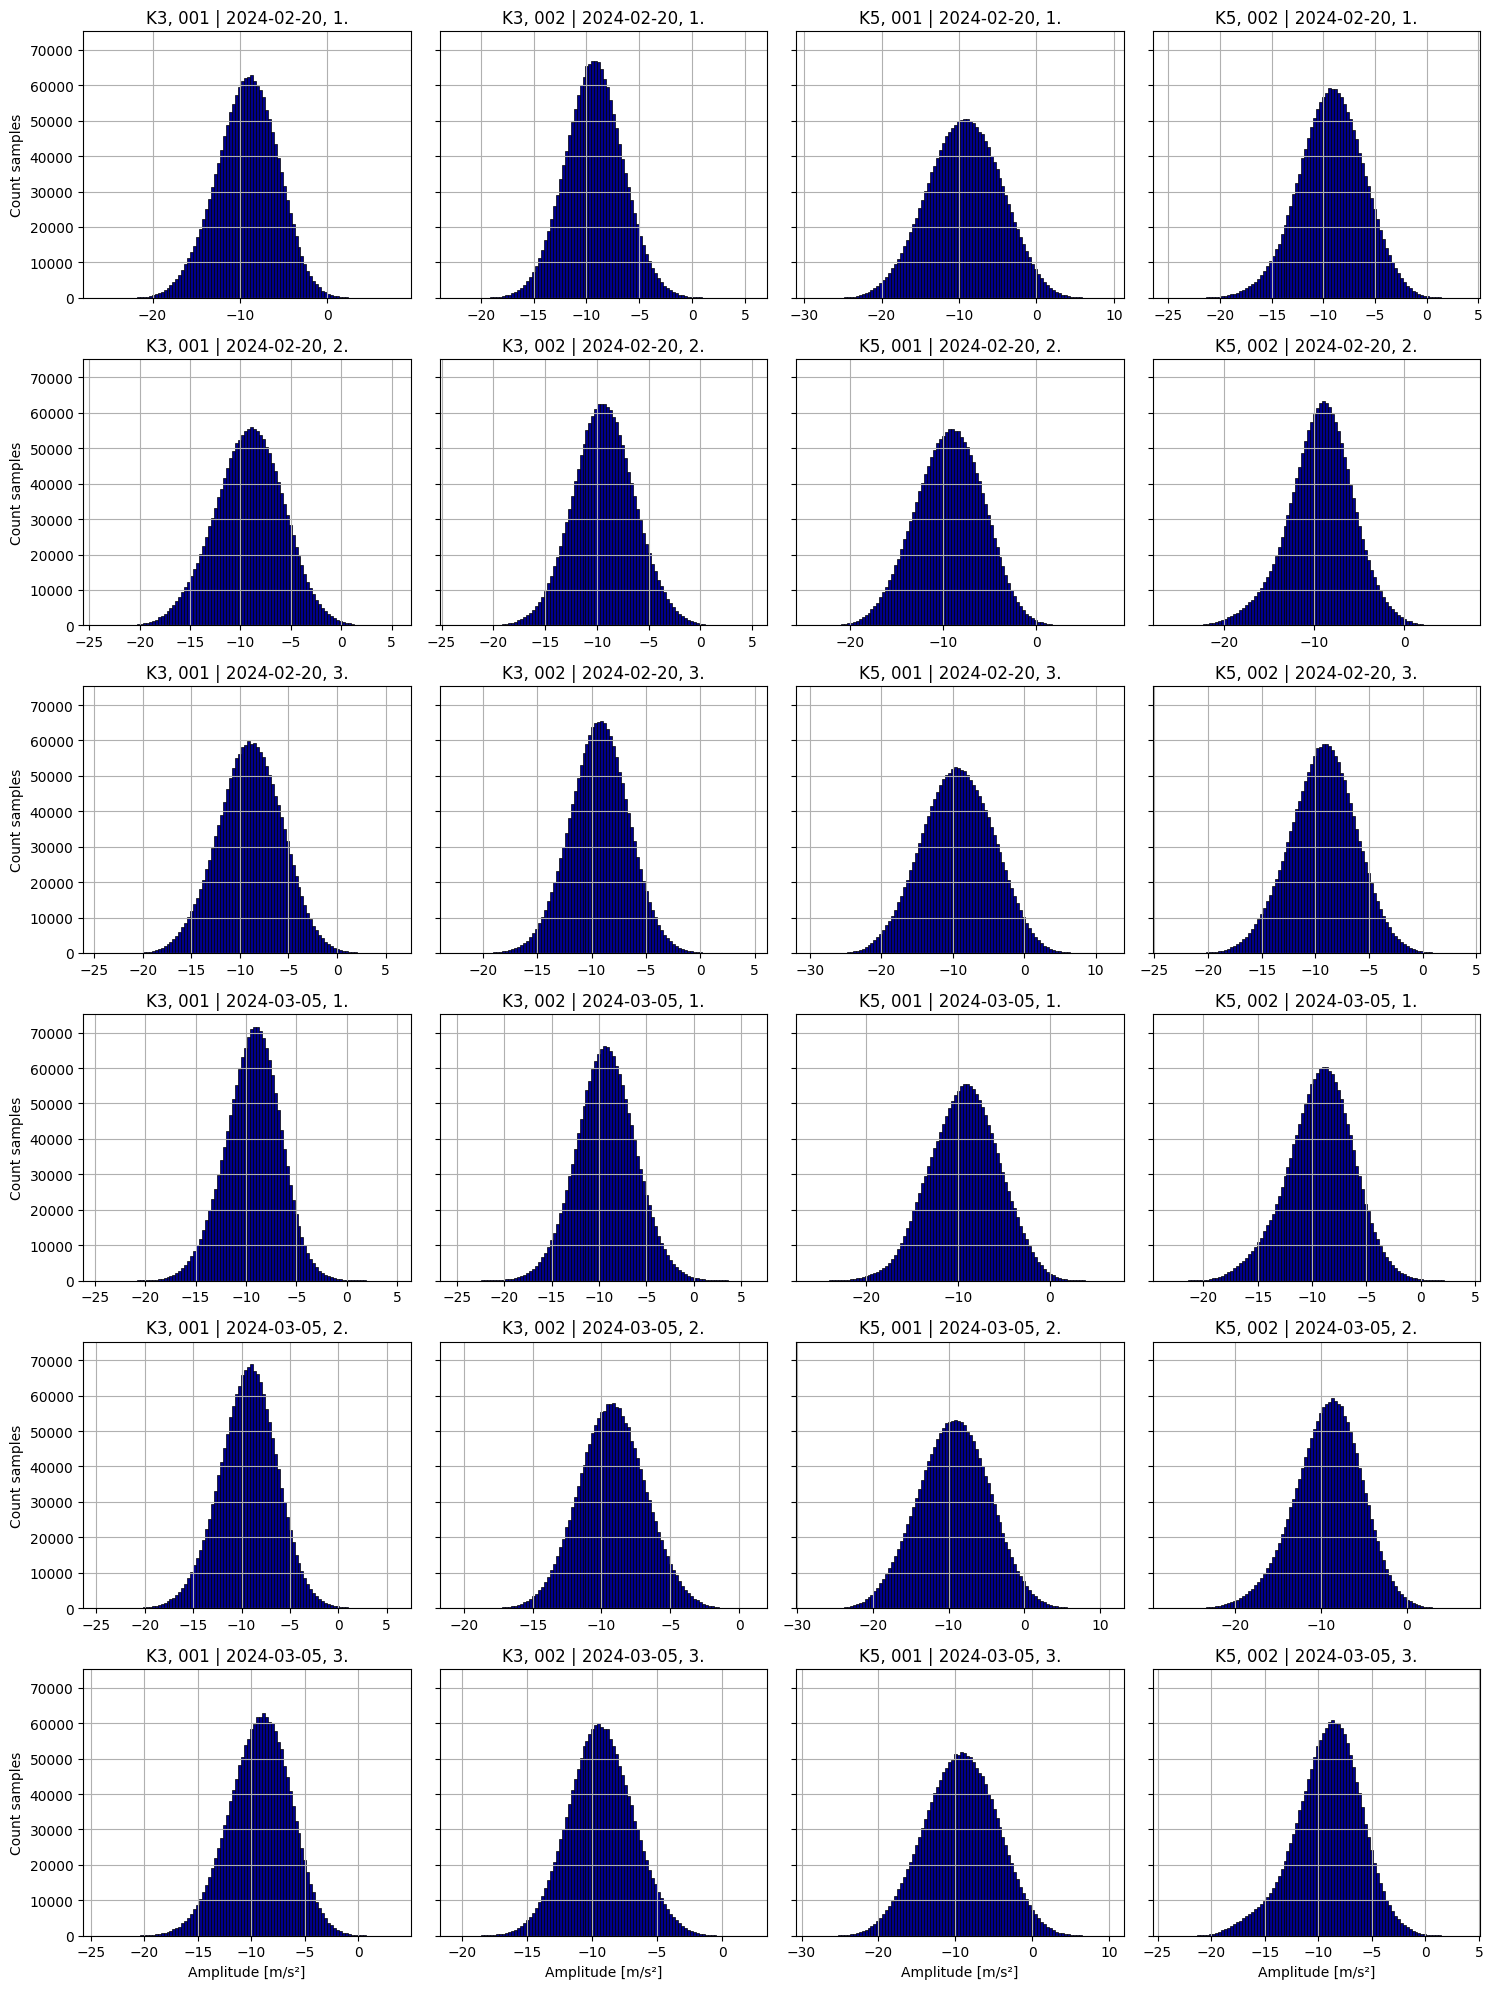

In [23]:
side_by_side(waveforms, 'compressor', 'hist', AXIS, figsize=(15, 20))

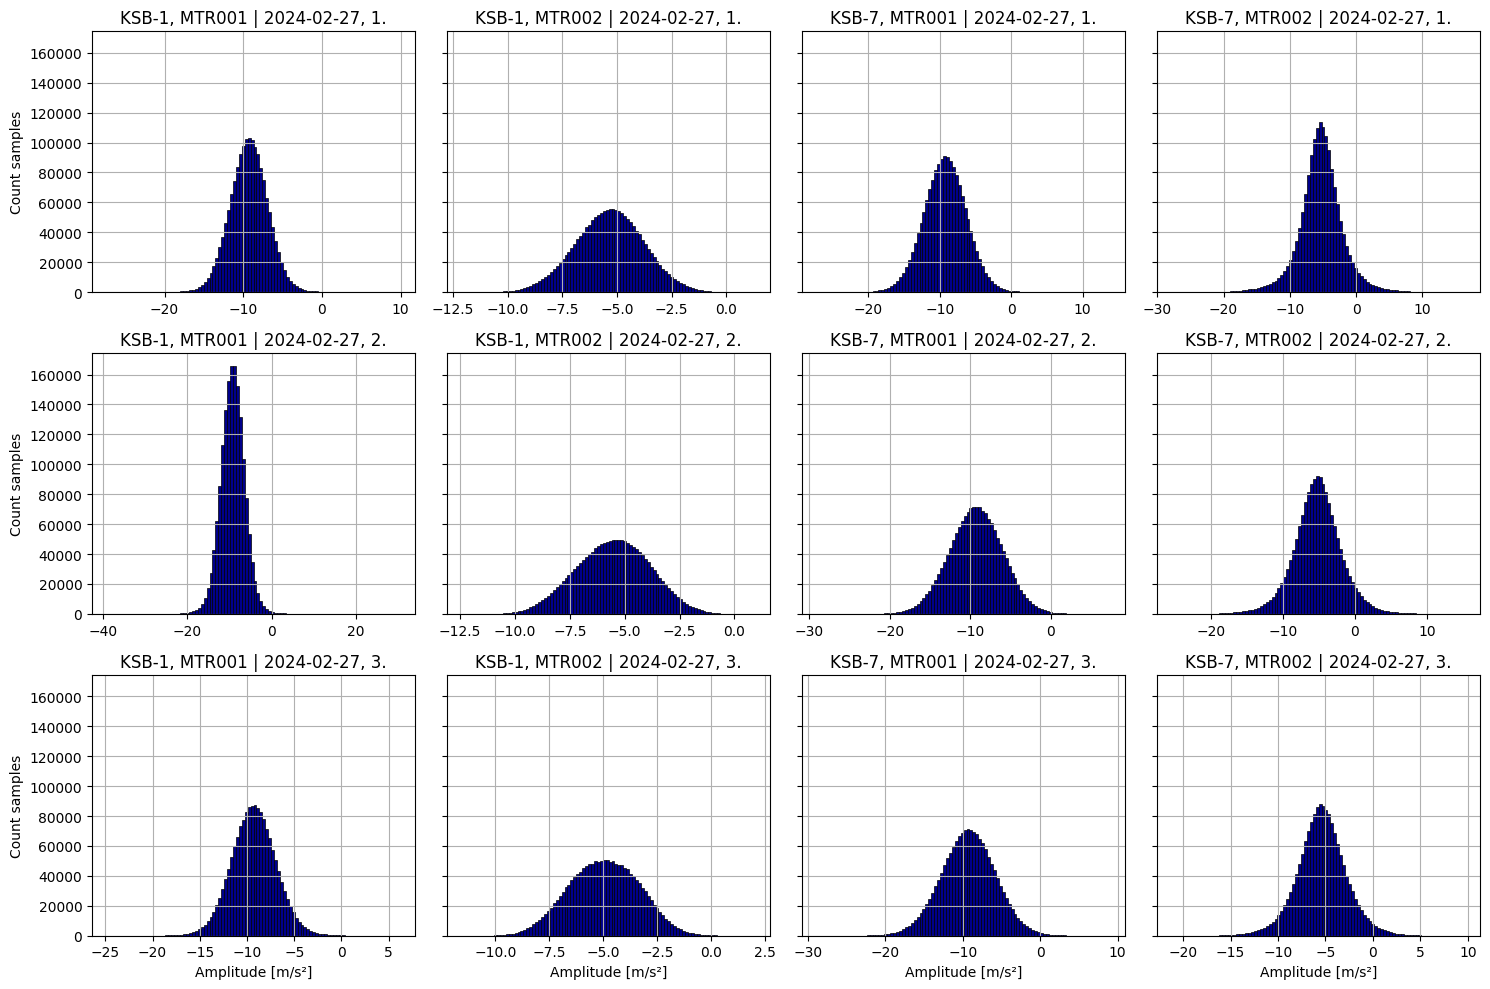

In [24]:
side_by_side(waveforms, 'pump', 'hist', AXIS, filt_pos='MTR', figsize=(15, 10))

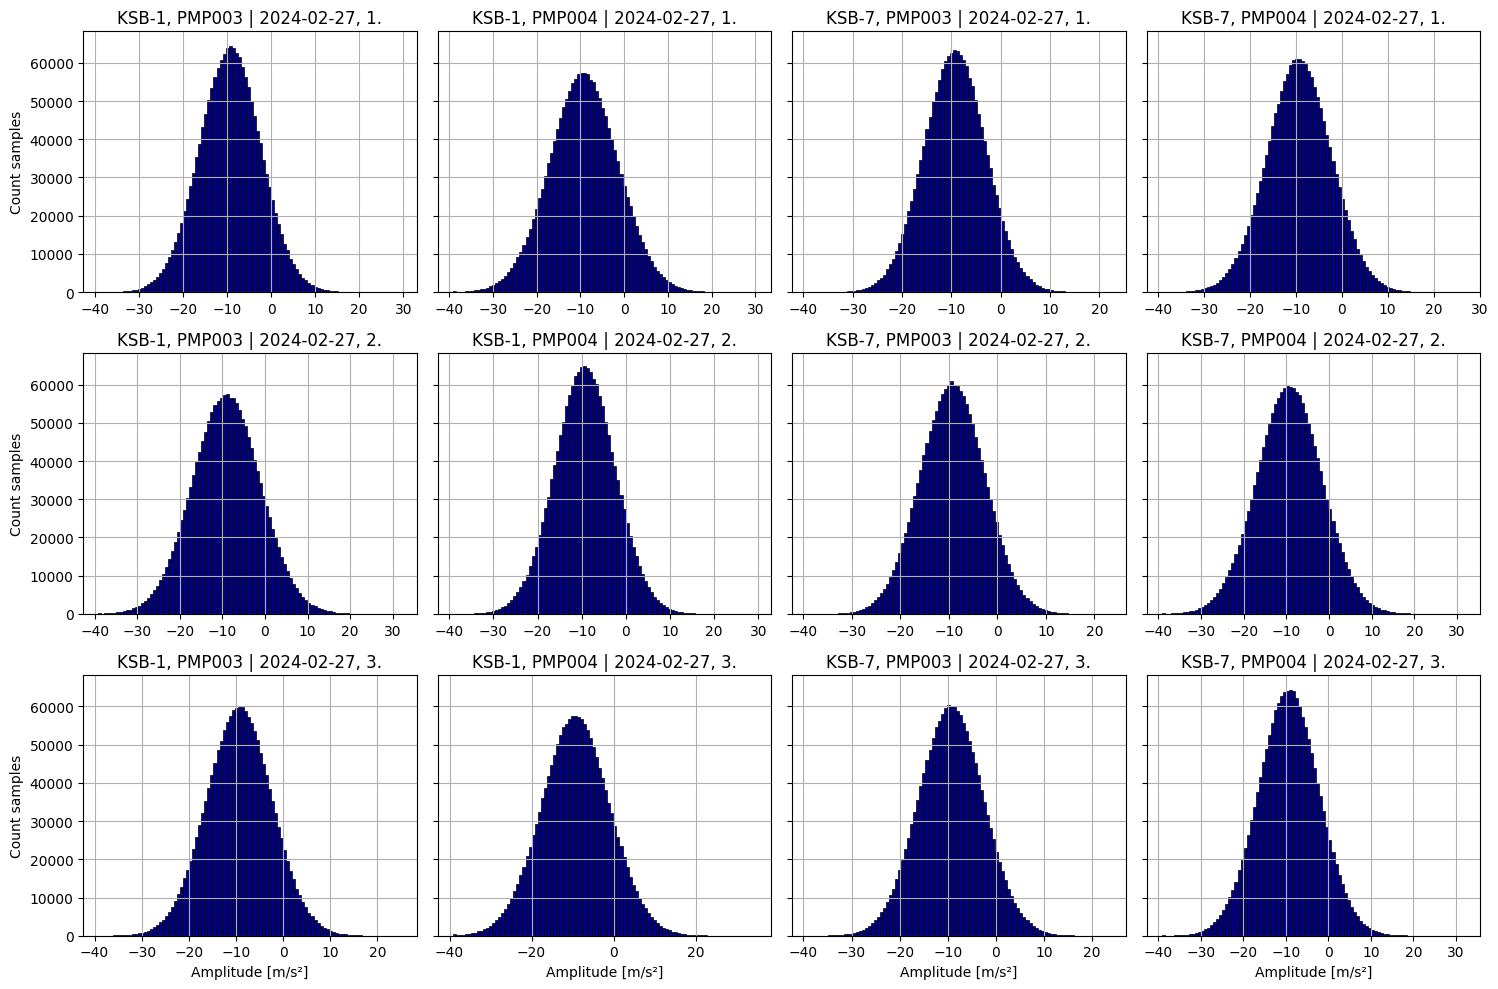

In [25]:
side_by_side(waveforms, 'pump', 'hist', AXIS, filt_pos='PMP', figsize=(15, 10))